In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Dicoding_Machine_Learning_2/Submission3

/content/drive/MyDrive/Dicoding_Machine_Learning_2/Submission3


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dir = 'cardataset'
train_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 13679 images belonging to 3 classes.
Found 3419 images belonging to 3 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input

base_model = tf.keras.applications.vgg16.VGG16(
    input_tensor=Input(shape=(150,150,3)),
    include_top=False,
    weights='imagenet'
)
for layer in base_model.layers:
    layer.trainable = False

prediction_layer = tf.keras.layers.Dense(3, activation='softmax')

#arsitektur VGG16 sudah mengandung conv2d dan maxpool
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  prediction_layer
])
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                         

In [6]:
class myCallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      print('Akurasi Tercapai')
      self.model.stop_training = True
callback = myCallbacks()

In [7]:
with tf.device('/GPU:0'):
  history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40,
    steps_per_epoch=128,
    batch_size=64,
    callbacks=[callback],
    verbose=2
    )

export_dir = 'trained_model/'
tf.saved_model.save(model, export_dir)

Epoch 1/40
128/128 - 1754s - loss: 1.5258 - accuracy: 0.8110 - val_loss: 0.2426 - val_accuracy: 0.9090 - 1754s/epoch - 14s/step
Epoch 2/40
128/128 - 1577s - loss: 0.2830 - accuracy: 0.8875 - val_loss: 0.2403 - val_accuracy: 0.8994 - 1577s/epoch - 12s/step
Epoch 3/40
128/128 - 1573s - loss: 0.2746 - accuracy: 0.8984 - val_loss: 0.2409 - val_accuracy: 0.9079 - 1573s/epoch - 12s/step
Epoch 4/40
128/128 - 1580s - loss: 0.2551 - accuracy: 0.9050 - val_loss: 0.1816 - val_accuracy: 0.9257 - 1580s/epoch - 12s/step
Epoch 5/40
128/128 - 1574s - loss: 0.2431 - accuracy: 0.9097 - val_loss: 0.2401 - val_accuracy: 0.9158 - 1574s/epoch - 12s/step
Epoch 6/40
Akurasi Tercapai
128/128 - 1572s - loss: 0.2130 - accuracy: 0.9202 - val_loss: 0.1893 - val_accuracy: 0.9237 - 1572s/epoch - 12s/step
INFO:tensorflow:Assets written to: trained_model/assets


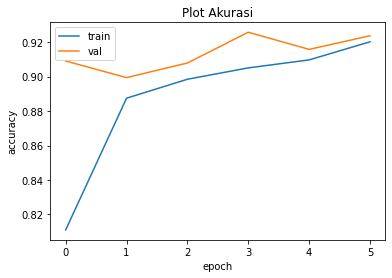

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Plot Akurasi')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

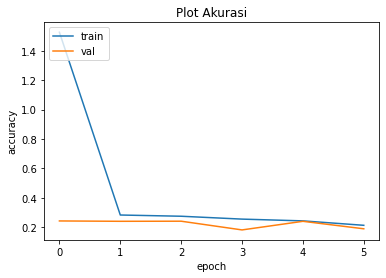

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Plot Akurasi')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
import pathlib
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

67390948